# Statistics on the output data. 

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random

warnings.filterwarnings("ignore")


database = '../data/IoTcode_contiki_rasp.db'
conn= connect(database)

dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)

if not os.path.exists("figure"):
    os.mkdir("figure")
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'cwe', 'context', 'helpuri', 'tool', 'severity', 'note', 'type',
       'project'],
      dtype='object')

In [14]:
dfs.cwe.value_counts()

Benign              960762
CWE-unknown          30702
CWE-120              15569
CWE-119!/CWE-120      9658
CWE-126               2383
CWE-190               2243
CWE-457               1859
CWE-120, CWE-20       1787
CWE-362                887
CWE-134                768
CWE-362/CWE-367!       626
CWE-562                378
CWE-327                330
CWE-570                320
CWE-78                 307
CWE-676                160
CWE-476                113
CWE-682                107
CWE-758                 91
CWE-732                 59
CWE-788                 49
CWE-685                 42
CWE-807, CWE-20         37
CWE-786                 35
CWE-377                 34
CWE-362, CWE-20         24
CWE-120/CWE-785!        11
CWE-775                  6
CWE-401                  6
CWE-369                  6
CWE-829, CWE-20          4
CWE-768                  3
CWE-250, CWE-22          1
Name: cwe, dtype: int64

In [16]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')
fig = px.sunburst(dfplt, path=['category', 'name', 'cwe'], values='count')
# fig.write_image("figure/vul_statistics.pdf")
fig.show()
dfplt.head()

,category,name,cwe,count
0,-,-,CWE-unknown,519
1,-,arrayIndexOutOfBounds,CWE-788,36
2,-,autoVariables,CWE-562,13
3,-,bufferAccessOutOfBounds,CWE-788,13
4,-,comparePointers,CWE-570,320


# Analysis of IoTvulCode tool generated output for feeding non-vul statements:


<AxesSubplot: >

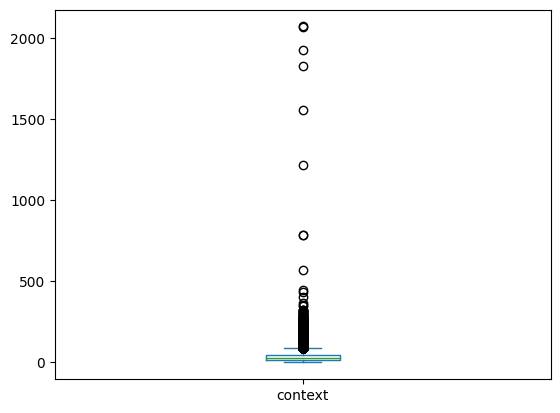

In [17]:
dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).plot(kind='box')

In [19]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 
    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    random.seed(0)
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 79
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dfm.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[1, 42, 41]

In [17]:
# df_dnn = pd.read_csv('../data/iDetect_refine/DNN_Binary.csv')
# df_conti = pd.read_csv('../data/contiki-master_Binary.csv')
# df_rasp = pd.read_csv('../data/raspberry_metrics.csv')
# df_rasp_flaw = pd.read_csv('../data/raspberry_flaw.csv')

# print('Shape of DNN data: ', df_dnn.shape)
# print('Shape of contiki: ', df_conti.shape)
# print('Shape of raspberry: ', df_rasp.shape)
# print('Shape of raspberry flaws: ', df_rasp_flaw.shape)

# dfcon = dfcon.rename(columns={'context': 'code'})
# dfcon.to_csv('../data/contiki-master_Binary.csv', index=False)

Shape of DNN data:  (4720, 2)
Shape of contiki:  (32889, 2)
Shape of raspberry:  (894715, 14)
Shape of raspberry flaws:  (78136, 20)


# Convert hyperparameters list to latex table format

In [21]:
def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config.yaml')

\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
hyperparameter &                           value \\
\midrule
        epochs &                              50 \\
         batch &                             128 \\
  input\_length &                             150 \\
     input\_dim &                             150 \\
    output\_dim &                              32 \\
            lr &                            1e-4 \\
      patience &                             100 \\
     optimizer &                            adam \\
        l2\_reg &                            1e-4 \\
       dropout &                             0.0 \\
 recur\_dropout &                             0.0 \\
        beta\_1 &                             0.9 \\
        beta\_2 &                           0.999 \\
       epsilon &                           1e-08 \\
         decay &                             0.0 \\
       verbose &                

In [34]:
len(dff.drop_duplicates(subset=['file', 'long_name', 'start_line', 'end_line', 'cwe'], keep='last').reset_index(drop=True))

209876

In [33]:
len(dff)

209876